In [18]:
# for dealing with data
import pandas as pd
import numpy as np

#for visualization
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns


#machine learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import PredefinedSplit

#for mathematics and statistics
import math
from scipy import stats
import scipy as sci
from scipy.spatial.distance import minkowski
from scipy.stats import spearmanr

# helpers file
from preprocessing_helper import *
from sampling_helper import *
from metrics_helper import *


#to mount google drive later
#from google.colab import drive


sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:

#Mount  Google Drive
#drive.mount('/content/drive')
#%cd drive/My\ Drive/Colab\ Notebooks/ML\ Project2

# Preprocessing

### Dataset import

In [3]:
# we import the dataset using pandas
df = pd.read_csv('data/GSM1586785_ScrH-12A_Exd_14mer_cg.csv')

In [4]:
# we visualize the first ten rows of our dataframe
df.head(10)

,Unnamed: 0,Kmer,y_1,y_2,y_3,y_4,y_5,y_6,zC_1,zC_2,...,zW_76,zW_77,zW_78,y_79,y_80,y_81,y_82,y_83,y_84,relKa
0,0,AATGATTAATTACC,0.593697,-1.092779,0.309117,0.133525,0.023403,-0.157348,1.177586,-2.166888,...,-0.674709,10.019444,-1.012806,-0.790300,-0.112492,0.118705,0.237596,-0.009713,0.267886,1.000000
1,1,GGTAATTAATCATT,0.790300,-0.112492,0.118705,-0.237596,-0.009713,0.267886,2.591673,-3.422281,...,-0.986852,9.851130,-1.990198,-0.593697,-1.092779,0.309117,-0.133525,0.023403,-0.157348,1.000000
2,2,AATGATTAATTACT,0.593690,-1.092780,0.309116,0.133525,0.023403,-0.157348,1.177587,-2.166890,...,-0.839165,10.065669,-1.499679,-0.826872,-1.141872,0.500342,-0.143809,0.043456,0.095141,0.968830
3,3,AGTAATTAATCATT,0.826872,-1.141872,0.500342,0.143809,0.043456,0.095141,2.137980,-2.777053,...,-0.986851,9.851129,-1.990198,-0.593690,-1.092780,0.309116,-0.133525,0.023403,-0.157348,0.968830
4,4,AGGTAATTAATCAT,1.260372,-0.870861,0.397555,0.124897,0.053255,0.213696,1.977567,-2.851909,...,-0.960712,9.943948,-1.806082,0.336528,-0.596511,0.184099,-0.075285,0.032807,0.149085,0.968752
5,5,ATGATTAATTACCT,-0.336528,-0.596511,0.184099,0.075285,0.032807,0.149085,1.689293,-2.713471,...,-0.880962,10.025845,-1.642795,-1.260372,-0.870861,0.397555,-0.124897,0.053255,0.213696,0.968752
6,6,GAATGATTAATTAC,0.913065,-0.050248,0.143538,-0.223040,0.018513,0.150335,1.664473,-2.791084,...,-1.250065,9.932713,-1.650592,0.378019,-0.119601,0.143364,0.200255,-0.000247,0.258814,0.962931
7,7,GTAATTAATCATTC,-0.378019,-0.119601,0.143364,-0.200255,-0.000247,0.258814,0.834275,-1.606688,...,-0.909342,9.914885,-1.620308,-0.913065,-0.050248,0.143538,0.223040,0.018513,0.150335,0.962931
8,8,AAGTAATTAATCAT,1.120371,-1.103292,0.321935,0.118111,0.038891,-0.068592,1.112401,-2.117575,...,-0.960720,9.943946,-1.806092,0.336478,-0.596498,0.184103,-0.075283,0.032807,0.149103,0.962317
9,9,ATGATTAATTACTT,-0.336478,-0.596498,0.184103,0.075283,0.032807,0.149103,1.689279,-2.713457,...,-1.116182,9.884140,-2.053728,-1.120371,-1.103292,0.321935,-0.118111,0.038891,-0.068592,0.962317


The dataframe has 321 columns, the column "Unnamed:0" corresponds clearly to the indices of our dataframe so it doesn't carry any additional information (we will drop it soon), the column "Kmer" contains the DNA sequences corresponding to each datapoint (a protein). The column "relKa" represents the probability that the protein is a binding site or not and it is a number from zero to one coming from experiments. Finally, the other columns are mechanical properties of the protein.

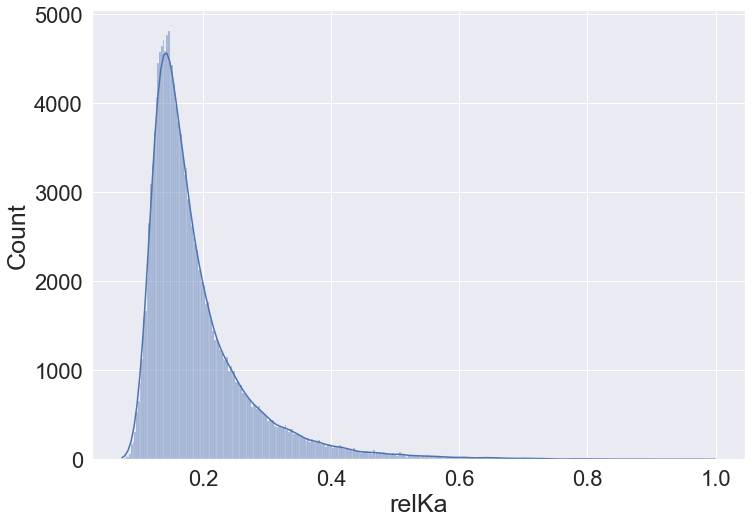

In [5]:
# we plot the distribution of the target label

sns.set(font_scale=2)
p = sns.histplot(data = df.relKa, kde=True)
p.set_xlabel("relKa", fontsize = 25) ## we want the labels to be big because we will use this plots in the report
p.set_ylabel("Count", fontsize = 25)
plt.show()

As we can observe the distribution is very skewed. Indeed, there are very few datapoints with a relKa bigger than 0.7. This makes our task quite hard since it is hard for a machine learning model to learn in the range of relKas between 0.7 and 1 because we have few datapoints in that range.

In [6]:
df.drop(columns = 'Unnamed: 0', inplace = True) # we drop the column with the indices
df.drop(columns = 'Kmer', inplace = True) # we drop the column with DNA sequences

We also tried to encode the DNA sequence instead of dropping with one hot encoding or sequential encoding but the final results were slightly worse.

### Splitting the dataset

In [7]:
# we divide our dataset in y labels and x label

y = df['relKa'].to_numpy()
x = df.loc[:, df.columns != 'relKa'].to_numpy()

In [8]:
# we split the x and y in x_0, x_1, y_0, y_1 where x_0 are all the features of the points with relka between 0 and 0.7, 
# x_1 are all the features of the points with relka between 0.7 and 1 and y_0,y_1 are the relKa corresponding to the two groups
# respectively


x_1,y_1,x_0,y_0 = split_importance(x,y)

We split by classes because we would like to have a training set, a validation set and a test set as representative as possible of both the classes.

In [9]:
# split the two classes seperately into train and test set to ensure representation of the minority class
# both in the test set, in the train set and in the validation one

# we split into train and test
x_1_train,x_1_test,y_1_train,y_1_test = train_test_split(x_1, y_1, test_size=0.20, random_state=42)
x_0_train,x_0_test,y_0_train,y_0_test = train_test_split(x_0, y_0, test_size=0.20, random_state=42)

# we further split the train in validation and training
x_1_train, x_1_val, y_1_train, y_1_val = train_test_split(x_1_train, y_1_train, test_size=0.20, random_state=42)
x_0_train, x_0_val, y_0_train, y_0_val = train_test_split(x_0_train, y_0_train, test_size=0.20, random_state=42)

# we stack together the two classes so that we have a unique class
x_train = np.concatenate((x_1_train,x_0_train))
y_train = np.concatenate((y_1_train,y_0_train))
x_val = np.concatenate((x_1_val, x_0_val))
y_val = np.concatenate((y_1_val, y_0_val))
x_test = np.concatenate((x_1_test,x_0_test))
y_test = np.concatenate((y_1_test,y_0_test))

### Outliers remotion

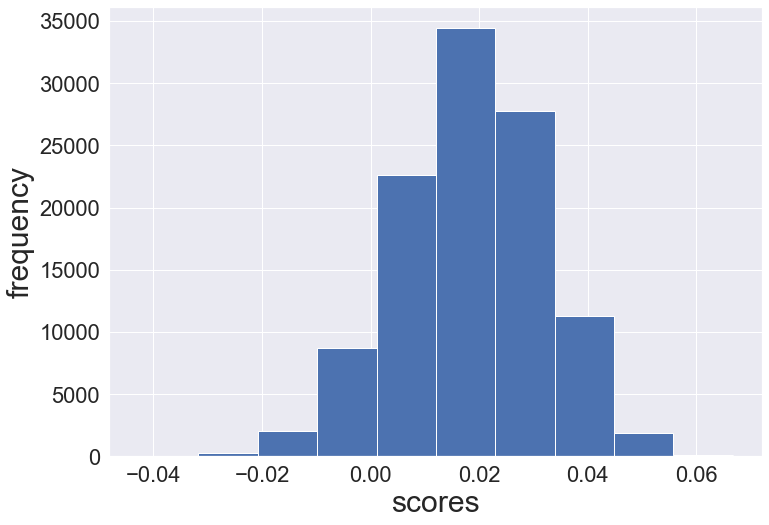

The indecision percentage around 0.02 is 0.5325406930411922
The percentage of outliers detected is 0.08918119280761375


In [10]:
# we apply the algorithm for outliers remotion
contamination, scores, outliers_indices = Anomaly_Detection_Isolation_Forests(x_train, change_split=False)

# we check that the algorithm is working properly
check_Isolation_Forests(contamination, outliers_indices, y_train)

# we plot the distribution of the scores
check_boundary_decision(scores, 0.02, verbose=1)

In [11]:
# we drop the outliers
x_train, y_train = drop_outliers(x_train, y_train, outliers_indices)

### Features scaling

In [12]:
# we create a scaler
sc = StandardScaler()

# we fit and scale on the train (we work with the mean and the std of the train)
x_train = sc.fit_transform(x_train)

# we use the same scaler (same mean and same std to scale the validation and the test set)
x_val = sc.transform(x_val)
x_test = sc.transform(x_test)

### We apply a transformation on the y labels (relKa values) to reduce skewness

In [13]:
# we modify the values of y-train with a coxbox transformation (used to reduce the skewness of the y labels)

y_train, fitted_lambda= stats.boxcox(list(y_train),lmbda=None)
y_train = np.array(y_train)
#print(fitted_lambda)

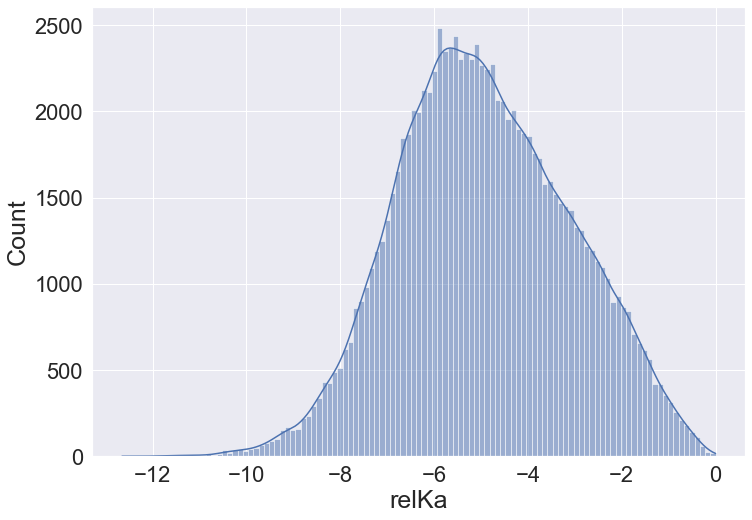

In [14]:
# we check the results of the transformation with a plot

sns.set(font_scale=2)
p = sns.histplot(data = y_train, kde=True)
p.set_xlabel("relKa", fontsize = 25)
p.set_ylabel("Count", fontsize = 25)
plt.show()

In [15]:
# we compute the new importance boundary after applying the boxcox transformation
importance_boundary = stats.boxcox([0.7,1.],fitted_lambda)[0]

### Sampling

We will apply both undersampling and oversampling to make the dataset more balanced on the training set

In [16]:
# we apply both undersampling and oversamping using PSU undersampling, at the end we will have 30% of points of the minority
# class and 70% of points of the majority class, we use correlation score as the matrix and PSU undersampling technique
x_train ,y_train = smote_sf(x_train, y_train, undersample=0.1, oversample=0.3,kneighbors=5, distance = 2.,
                              undersampling = PSU_undersampling_regression ,attribute_scorer= Correlation_Score_Max,
                              importance_class = importance_boundary)
# we shuffle the data to ensure randomness
p = np.random.permutation(len(y_train))
x_train = x_train[p]
y_train = y_train[p]

# Training

In [19]:
# we use XGB regressor model with the following hyperparameters

model = XGBRegressor(subsample = 0.8999999999999999, n_estimators= 500,
                     max_depth = 20, learning_rate = 0.01, colsample_bytree = 0.7999999999999999, colsample_bylevel = 0.6, obj=penalized_MSE )
model.fit(x_train, y_train,eval_metric=penalized_MSE_train)
predictions = model.predict(x_test)

In [20]:
# we scale back the predictions and we compute the MSE and the penalized MSE

predictions = sci.special.inv_boxcox(predictions, fitted_lambda)
print('the MSE for tuned model XGB Regressor is',MSE(y_test, predictions))
print('the weighted-MSE for tuned model XGB Regressor is',penalized_MSE(y_test, predictions))

the MSE for tuned model XGB Regressor is 0.003298096918918044
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65]
[0.72502145 0.79381635 0.72175077 ... 0.21714475 0.14845979 0.19741368] [3.45787   3.6773868 3.559542  ... 1.2884057 1.1849322 1.2187922]
the weighted-MSE for tuned model XGB Regressor is 7.728420622358379


We visualize the MSE for ranges of values of relKa

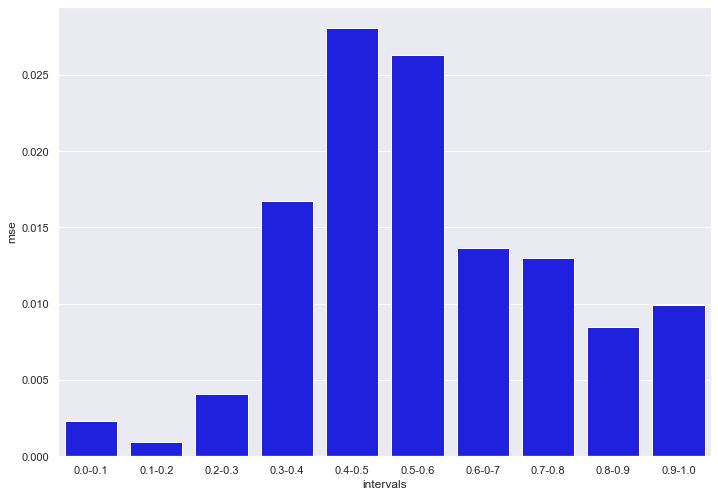

In [21]:
range_values = np.arange(0.05,1.05,0.1)
mse_ranges = []
for val in range_values:
    labels_range = y_test[np.where(np.abs(y_test-val)<=0.05)]
    correspondent_predictions = predictions[np.where(np.abs(y_test-val)<=0.05)]
    mse_ranges.append(MSE(correspondent_predictions, labels_range))
sns.set(rc={'figure.figsize':(11.7,8.27)})
intervals = ['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4','0.4-0.5', '0.5-0.6', '0.6-0-7', '0.7-0.8', '0.8-0.9', '0.9-1.0']
dict_mse = {'intervals': intervals, 'mse': mse_ranges}
df_mse = pd.DataFrame.from_dict(dict_mse)
sns.barplot(x = df_mse['intervals'], y = df_mse['mse'], color='blue')
plt.show()

# Error Analysis

In [22]:
# we plot the curve of loss vs iterations for the training and test set to understand if we are overfitting or not
training_scores, testing_scores = score_metrics(x_train, x_test, y_train, y_test, iterations=1)

NameError: name 'fitted_lambda' is not defined

In [ ]:
# we set as significant errors all the errors which are off by more than 0.15 from the true labels
indices_significant_errors = np.where(np.abs(predictions-y_test)>0.15)[0]

# we create a vector with the x, y of the errors and the x, y of the correct ones
x_errors = x_test[indices_significant_errors, :]
y_errors = y_test[indices_significant_errors]
x_correct = np.delete(x_test, indices_significant_errors, axis=0)
y_correct = np.delete(y_test, indices_significant_errors, axis=0)

In [ ]:
# we create a df with the errors and the correct ones

df_errors = pd.DataFrame(data=x_errors)
df_correct = pd.DataFrame(data=x_correct)
df_errors[318] = y_errors
df_correct[318] = y_correct
df_errors['label'] = 1
df_correct['label'] = 0


df_to_study = pd.concat([df_correct, df_errors], axis=0)

In [ ]:
# we plot the distribution of the errors for each feature

fig, ax = plt.subplots(80,4, figsize=(14,400))
for i in range(df_to_study.shape[1]):
    sbplt = ax[i%80, math.floor(i/80)]
    df_0 = df_to_study[df_to_study['label']==0]
    df_1 = df_to_study[df_to_study['label']==1]
    sbplt.hist(df_0.iloc[:,i], bins =100, alpha=0.5, label='correct', color='r',log=True)
    sbplt.hist(df_1.iloc[:,i], bins =100, alpha=0.5, label='error', color='b', log=True)
    sbplt.set_title('column: {}'.format(i))
fig.tight_layout()

It is difficult to notice some meaningful differences.

# Hyperparameters tuning

In [ ]:
# we stack together train and validation set

train_val_x = np.concatenate((x_train, x_val))
train_val_y = np.concatenate((y_train,y_val))

In [ ]:
# we create my_test_fold which is a list containing -1 if the point associeted with the index is in the train, zero otherwise

my_test_fold = [-1 if i<np.shape(x_train)[0] else 0 for i in range(train_val_x.shape[0])]

# we use predefinedsplit to create the validation fold

ps = PredefinedSplit(test_fold=my_test_fold)

In [ ]:
# we set the grid of parameters

params = { 'max_depth': [5, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.5],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.5, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
           'n_estimators': [100,500,1000]
            }

# we create the scorer
score = make_scorer(penalized_MSE_train, greater_is_better=False)

# we create the model
model = XGBRegressor(tree_method='gpu_hist',seed = 20)

# we apply randomized search to select the best hyperparameters using a fixed validation set x_val, y_val
clf = RandomizedSearchCV(estimator = model,
                         param_distributions = params,
                         scoring = score,
                         n_iter=10,
                         cv = ps,
                         verbose=10)
# we fit to produce the new results
clf.fit(train_val_x, train_val_y, eval_metric = penalized_MSE)